This notebook serves as a reference to how the datasets used in this analysis were created and stored. 

Datasets included: 

- Profiles and Control parameters from time windows contained in: 
    - JET Pedestal Database (L. Frassinetti)
        - The raw HRTS signals. 
    - AUG Pedestal Database (M. Dunne)
        - The signals processed by IDA. 
        
After pulling the relevant pulses from respective machine data channels, we process and gather. 
- Averaging of control parameters across time slices 
- Types of data

Then we store the datasets in a python-serialized format. 
- Dictionary 
- Python Class


In [74]:
import pickle
import numpy as np
import pandas as pd
from scipy import interpolate, integrate
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm 
from IPython.display import display, HTML

## Raw Format

The raw dict taken from (JET PPF via Heimdall)/(AUG PPF via TBD) was stored into key-value form:

- Pulse_num (e.g., `'75623'`)
    - `'inputs'`
        - a key in `['Q95', 'RGEO', 'CR0', 'VOLM', 'TRIU', 'TRIL', 'ELON', 'POHM', 'IPLA', 'BVAC', 'NBI', 'ICRH', 'ELER', 'VJAC', 'TBEO']`
            - each key has following keys `['time', 'values']`, with the exception of VJAC, which has `'radius'` as well
    - `'outputs'`
        - a key in `['NE', 'DNE', 'DTE', 'TE', 'RHO', 'RMID', 'PSI', 'FAIL']`
            - each key has following keys `['time', 'radius', 'values']`
        
        
        
An example of how to access the density values for pulse number 75623: 

`ne = raw_dict['75623']['outputs']['NE']['values']`

The input keys that may cause confusion: 
- `IPLA`: Plasma current 
- `VJAC`: Jacobian of volume (dV/dPsi)
- `TBEO`: Berylium count 
- `CR0`: Minor radius 

## Dataset Format
A dataset for quick access for others to use for training/testing models should include the following: 
- Train-val-test splits (a quick access dictionary) 
    - Each split should have the following atributes: 
        - Documentation (pulses/time-slices/indexes of pulse num matching profile)  
        - NE + TE; NE_UNC+TE_UNC; RADII; CONTROLS; (if applicable: MASKS;)
        - Preprocessing done, e.g., raw vs fitted vs padded. 



In [125]:
# From the raw data pulled from respective databases: 

# JET: profile_database_only_shots.hdf5
# AUG: AUG_pdb_pulses_raw_data.pickle

# My personal loaction to data: /home/kitadam/ENR_Sven/moxie_revisited/data/raw/

PERSONAL_DATA_DIR = '/home/kitadam/ENR_Sven/moxie/data/raw/'
PERSONAL_DATA_DIR_PROC = '/home/kitadam/ENR_Sven/moxie/data/processed/'
JET_RAW_FILE_LOC = PERSONAL_DATA_DIR + 'JET_pdb_pulses_raw_data.pickle' # 'JET_pdb_pulses_raw_with_bo.pickle' #'JET_pdb_pulses_raw_data.pickle'
JET_PDB_FILE_LOC = PERSONAL_DATA_DIR + 'jet-pedestal-database.csv'

with open(JET_RAW_FILE_LOC, 'rb') as file: 
    JET_RAW_DICT = pickle.load(file)

JET_PDB = pd.read_csv(JET_PDB_FILE_LOC) 



AUG_RAW_FILE_LOC = PERSONAL_DATA_DIR + 'AUG_pdb_pulses_raw_data.pickle'
AUG_PDB_FILE_LOC = PERSONAL_DATA_DIR + 'AUG_PEDDB_20210422.dat'
rel_ped_cols = ['Tepedheight(keV)', 'nepedheight10^19(m^-3)']
time_cols = ['FLAG:HRTSdatavalidated', 't1', 't2']
rel_global_cols = ['Zeff', 'BetaN(MHD)']
rel_mp_cols = [ 'Ip(MA)', 'B(T)', 'R(m)', 'a(m)', 'averagetriangularity', 'Meff', 'P_NBI(MW)', 'P_ICRH(MW)', 'P_TOT=PNBI+Pohm+PICRH-Pshi(MW)', 'plasmavolume(m^3)', 'q95', 'gasflowrateofmainspecies10^22(e/s)']

# with open(AUG_RAW_FILE_LOC, 'rb') as file: 
#     AUG_RAW_DICT = pickle.load(file)

1.) Gather lists of shots from JET PDB into groups that will become datasets. 

- Datasets: 
    - Common to all: 
        - Time windows in JET PDB 
        - HRTS validated
    1. Sandbox (DF CODNAME: `PULSE_DF_SANDBOX`)
        - ILW (Shot >= 80000)
        - Nitrogen seeding or none (Atomicnumberofseedingimpurity = 7 | 0
        - Deuterium fuel (FLAG:DEUTERIUM == 1.0)
        - No Kicks, RMPs, Pellets (FLAG:Kicks, RMP, pellets == 0.0)
        - try to get rid of as many Te spikes (need to check using routine)
    2. Full (`PULSE_DF_ALL`)
        - Both walls 
        - Mulitple Isotopes 
        - Multiple seedings 
        - Kicks, RMPs, Pellets

Some pulses have multiple time slices.
To quantitivly discuss the effect on performance, we store three versions of each dataset. 
- Without the pulses that multiply occur
- Without the pulses that neped varies more than 0.5 between time slices 
- No changes

Each dataset then has a dictionary associated with it that accounts for what parameter varies the most and the full list of pulses that occur multiple times
`variations_sandbox`, `variations_all`. 

In [158]:
PULSE_DF_ALL = JET_PDB[(JET_PDB['FLAG:HRTSdatavalidated'] > 0)]
PULSE_DF_SANDBOX = JET_PDB[(JET_PDB['FLAG:HRTSdatavalidated'] > 0) & (JET_PDB['shot'] > 80000) & (JET_PDB['Atomicnumberofseededimpurity'].isin([0, 7])) & (JET_PDB['FLAG:DEUTERIUM'] == 1.0) & (JET_PDB['FLAG:Kicks'] == 0.0) & (JET_PDB['FLAG:RMP'] == 0.0) & (JET_PDB['FLAG:pellets'] == 0.0)]

# print(PULSE_DF.columns.to_list())
print('Sandbox', 'All')
PULSE_set_all = list(set(PULSE_DF_ALL['shot'].to_list()))
PULSE_set_sandbox = list(set(PULSE_DF_SANDBOX['shot'].to_list()))
print('# time slices')
print(len(PULSE_DF_SANDBOX), len(PULSE_DF))
print('# unique pulses')
print(len(PULSE_set_sandbox), len(PULSE_set_all))

from collections import Counter

doubled_sandbox = list((item, count) for item, count in Counter(PULSE_DF_SANDBOX['shot'].to_list()).items() if count >= 2)
doubled_all = list((item, count) for item, count in Counter(PULSE_DF_ALL['shot'].to_list()).items() if count >= 2)
print('# pulses that occur twice')
print(len(doubled_sandbox), len(doubled_all))
# print(doubled_sandbox)
print('Total # time slices from doubled pulses')
print(sum(Counter(dict(doubled_sandbox)).values()), sum(Counter(dict(doubled_all)).values()))
# This is to check the numbers add up... 
assert len(PULSE_set_sandbox) - len(doubled_sandbox) + sum(Counter(dict(doubled_sandbox)).values()) == len(PULSE_DF_SANDBOX)

"""
Find the variations in the pulses, and store it in a dictionary 
"""

variations = {'all': []}
for n, (item, count) in enumerate(doubled_sandbox): 
    # print(item, count)
    doubled_df = PULSE_DF_SANDBOX[PULSE_DF_SANDBOX['shot'] == item][time_cols + rel_ped_cols  + rel_mp_cols]
    diff = doubled_df[rel_ped_cols  + rel_mp_cols].diff(axis=0).abs()
    # What parameter chagned the most during the shot
    changes_val, changes_id = diff.iloc[1].max(), diff.iloc[1].idxmax(axis=1)
    if changes_id in variations.keys(): 
        variations[changes_id]['count'] += 1
        variations[changes_id]['pulse_ids'].append(item)
    else: 
        variations[changes_id] = {'count': 1, 'pulse_ids': [item]} 
    variations['all'].append(item)
variations_sandbox = variations.copy()

variations = {'all': []}
for n, (item, count) in enumerate(doubled_all): 
    doubled_df = PULSE_DF_ALL[PULSE_DF_ALL['shot'] == item][time_cols + rel_ped_cols  + rel_mp_cols]
    diff = doubled_df[rel_ped_cols  + rel_mp_cols].diff(axis=0).abs()
    # What parameter chagned the most during the shot
    changes_val, changes_id = diff.iloc[1].max(), diff.iloc[1].idxmax(axis=1)
    if changes_id in variations.keys(): 
        variations[changes_id]['count'] += 1
        variations[changes_id]['pulse_ids'].append(item)
    else: 
        variations[changes_id] = {'count': 1, 'pulse_ids': [item]} 
    variations['all'].append(item)
variations_all = variations.copy()

Sandbox All
# time slices
1241 2471
# unique pulses
976 1859
# pulses that occur twice
231 517
Total # time slices from doubled pulses
496 1129


# Overview of functions used for obtaining the dataset
All times here are ***real time***, i.e., the real seconds within the experiment. 
#### Time Windowing

We shorten the HRTS signal to the given time windows found in the JET PDB (start: $t_1 \rightarrow$ end: $t_2$). The window in the JET PDB is used to average over an ELM cycle.

For the given HRTS measurement at time $t_m$, the parts of the signal stored in this analysis is that which $t_1 \leq t_m \leq t_2$. The function that does this is `get_profile_window_times(pulse_profs, t1, t2)`


#### Windowing of Machine Parameters 
Different machines have different diagnostics, so we outline the windowing procedure based on each machine. 
Each machine parameter may also have a varying sampling rate, often different from the HRTS measurement sampling rate. This causes the machine parameters to be on a different time-axis than that of the HRTS measurement, therefore we must align them to a common time-domain. To do so, we define a time-window, which we then interpolate the machine parameters across in order to get the resulting machine parameter onto the same time-domain as the HRTS signal.  The time at which the machine parameter measurement is taken is denoted as $t_x$, and the time of the HRTS measurement is denoted as above, $t_m$. 

This is normally not an issue for flat-top H-mode pulses, especially for machine parameters like plasma current, magnetic field, 


##### **JET**
The measurement frequency of the HRTS system at JET is 20Hz, or once every 0.05 seconds, therefore $\Delta T = 0.05$. 

##### **AUG**

TBD 

#### Masking profiles

$T_e$ sucks at the wall. 

0it [00:00, ?it/s]

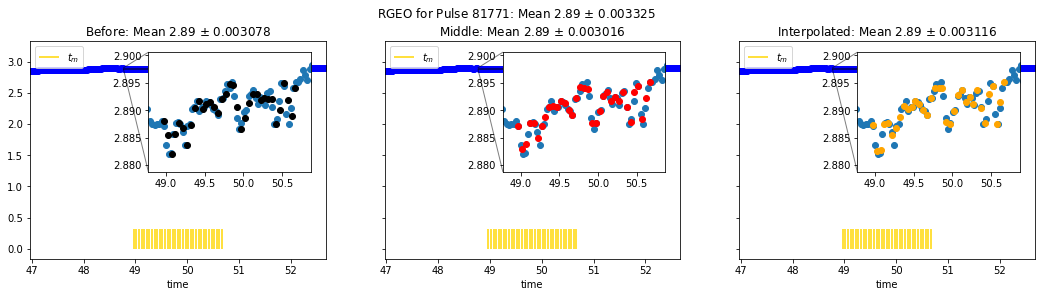

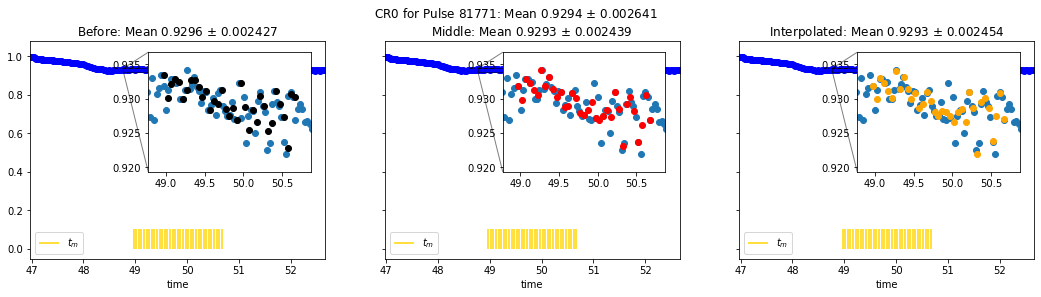

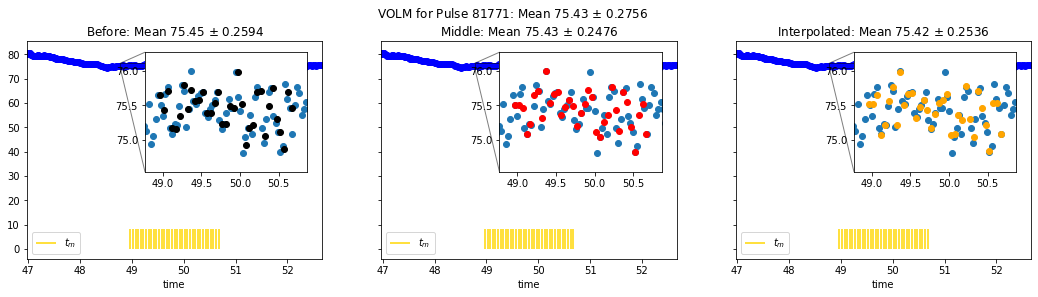

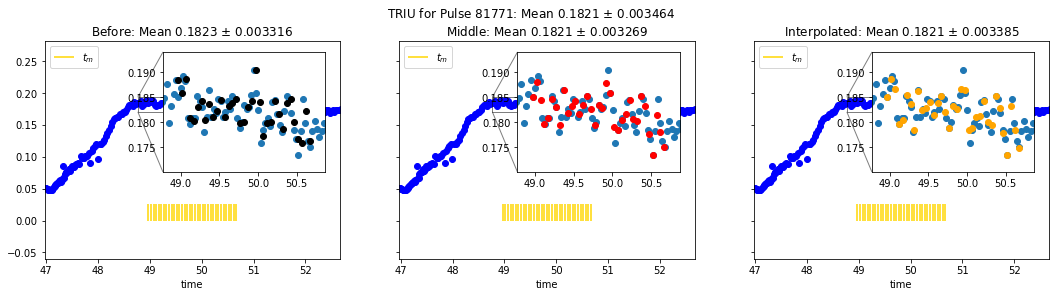

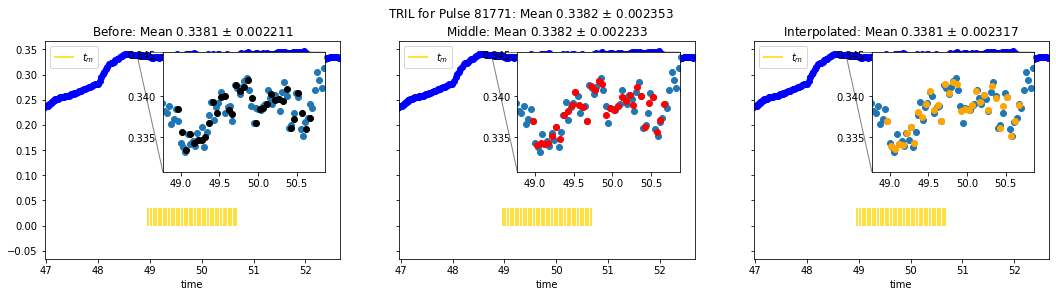

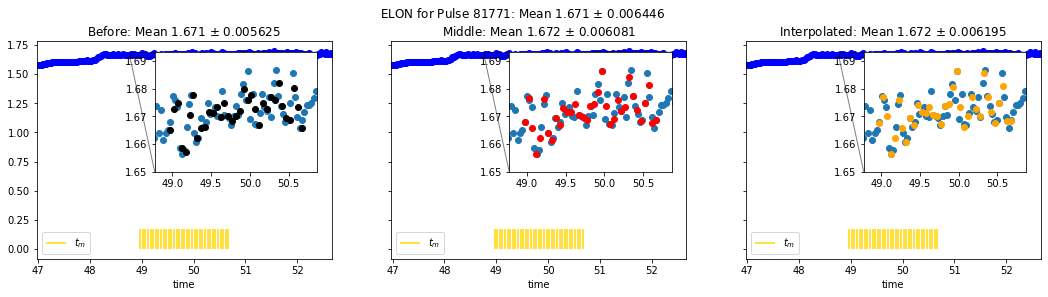

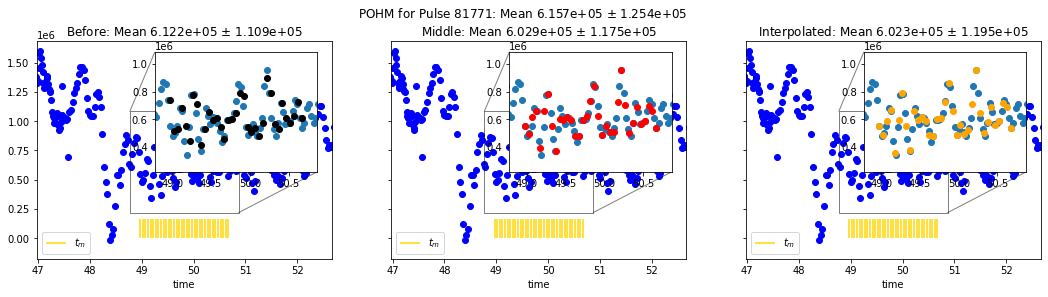

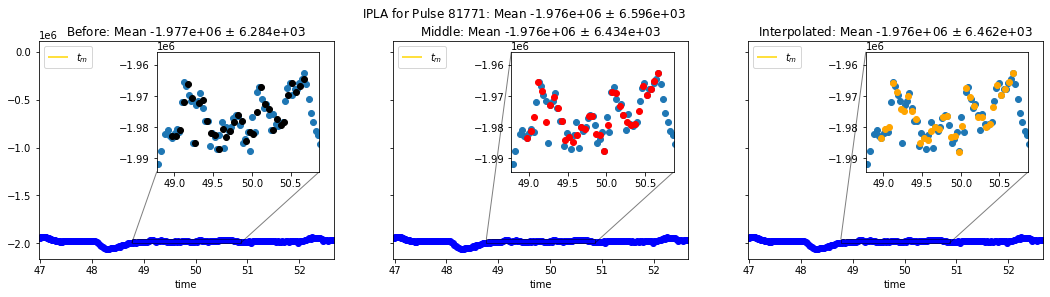

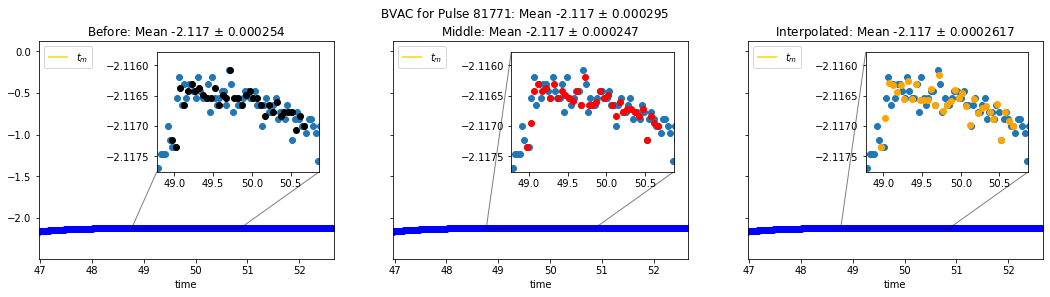

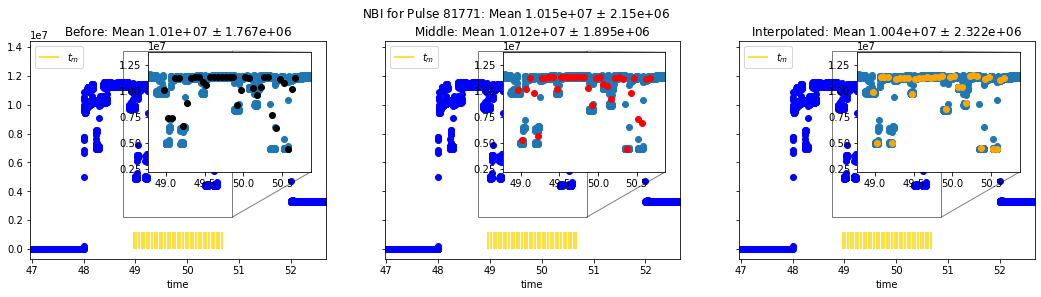

/tmp/ipykernel_53565/2556545820.py:148: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  axins.set_ylim(min(all_mp_values) - np.std(all_mp_values), max(all_mp_values) +np.std(all_mp_values))


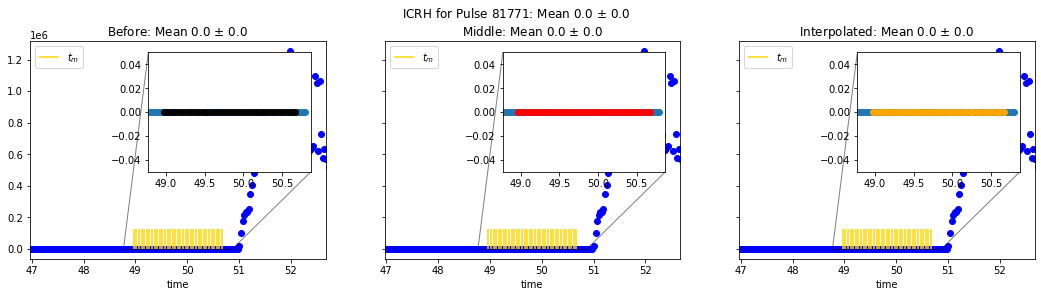

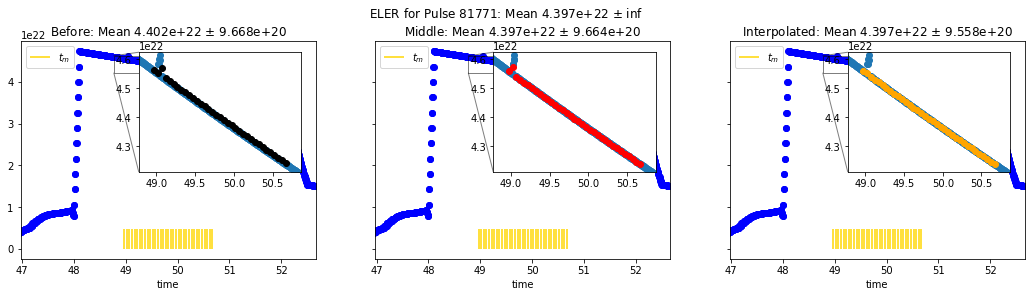

In [268]:
plt.close('all')
# Plotting Routines: 
def shift_radius(rho_slices, psi_slices, rmid_slices):
    radii_shfited = np.zeros_like(rmid_slices)
    
    rseps = np.zeros(len(rho_slices))
    
    for n, (slice_psi, slice_rho) in enumerate(zip(psi_slices, rho_slices)): 
        
        rho_psi_interp_radius = np.linspace(3.5, rmid_slices[n].max(), 1000)
        
        # Interpolate psi and rho to get rsep, shich is where rho = psi
        f_psi = interpolate.interp1d(rmid_slices[n], slice_psi)
        f_rho = interpolate.interp1d(rmid_slices[n], slice_rho)
        
        new_psi = f_psi(rho_psi_interp_radius)
        new_rho = f_rho(rho_psi_interp_radius)
        
        diff_from_rho = np.abs(new_psi - new_rho)
        closest_to_rho = np.argmin(diff_from_rho)
        
        rsep = rho_psi_interp_radius[closest_to_rho]
        rseps[n]  = rsep
        
        new_radius = rmid_slices[n] - rsep
        radii_shfited[n] = new_radius

    return radii_shfited

def plot_profile_radii(pulse_profs, time_window_mask, RMID, RADII_SHIFTED, PSI, plotting=False): 
    d_profs, t_profs = pulse_profs['NE']['values'][time_window_mask], pulse_profs['TE']['values'][time_window_mask]
    og_radius = pulse_profs['NE']['radius']
    d_cut, t_cut, stored_int = [], [], []
    plt.close()
    fig, axs = plt.subplots(3, 4, constrained_layout=True, figsize=(12, 10))
    
    axs = axs.ravel()
    
    for n, (d_prof, t_prof) in enumerate(zip(d_profs, t_profs)): 
        pedestal_mask = np.logical_and(RADII_SHIFTED[n] > -0.15, RADII_SHIFTED[n] < 0.05)
        axs[0].scatter(og_radius[pedestal_mask], d_prof[pedestal_mask])
        axs[2].scatter(RADII_SHIFTED[n][pedestal_mask], d_prof[pedestal_mask])
        axs[1].scatter(RMID[n][pedestal_mask], d_prof[pedestal_mask])
        axs[3].scatter(PSI[n][pedestal_mask], d_prof[pedestal_mask])
        
        axs[4].scatter(og_radius[pedestal_mask], t_prof[pedestal_mask])
        axs[6].scatter(RADII_SHIFTED[n][pedestal_mask], t_prof[pedestal_mask])
        axs[5].scatter(RMID[n][pedestal_mask], t_prof[pedestal_mask])
        axs[7].scatter(PSI[n][pedestal_mask], t_prof[pedestal_mask])
        
        axs[8].scatter(og_radius[pedestal_mask], (d_prof*t_prof)[pedestal_mask])
        axs[10].scatter(RADII_SHIFTED[n][pedestal_mask], (d_prof*t_prof)[pedestal_mask])
        axs[9].scatter(RMID[n][pedestal_mask], (d_prof*t_prof)[pedestal_mask])
        axs[11].scatter(PSI[n][pedestal_mask], (d_prof*t_prof)[pedestal_mask])
        # if n == 6: 
        #     break
        
    axs[0].set_ylabel('Density [m-3]', fontsize='x-large')  
    axs[4].set_ylabel('Temperature [eV]', fontsize='x-large')
    axs[8].set_ylabel('Pressure [eV m-3]', fontsize='x-large')
    axs[8].set_xlabel('HRTS RADIUS')
    axs[10].set_xlabel('$R_{mid} - R_{mid,sep}$')
    axs[9].set_xlabel('$R_{mid}$')
    axs[11].set_xlabel('$\Psi$')
    plt.show()
    
def do_sample_plot(PULSE_DF): 
    MP_NAME_LIST = ['Q95', 'RGEO', 'CR0', 'VOLM', 'TRIU', 'TRIL', 'ELON', 'POHM', 'IPLA', 'BVAC', 'NBI', 'ICRH', 'ELER']
    
    pbar = tqdm(PULSE_DF.iterrows())    
    i = 0
    for index, row in pbar: 
        i += 1
        if i < 2: 
            continue
        pulse_num, t1, t2 = int(row['shot']), row['t1'], row['t2']
        pulse_mps, pulse_profs = JET_RAW_DICT[str(pulse_num)]['inputs'], JET_RAW_DICT[str(pulse_num)]['outputs']
        
        # Find the time windows used in JET PDB ELM AVERAGING (ABSOLUTE TIME)
        time_windows, time_window_mask = get_profile_window_times(pulse_profs, t1, t2)
        for key in MP_NAME_LIST: 
            mp_val, mp_time = pulse_mps[key]['values'], pulse_mps[key]['time']
            plot_mp_windows(mp_val, mp_time, time_windows, delta_T = 0.05, title={'id': key, 'shotnum': pulse_num})
        break
        
    pass 

def plot_mp_windows(mp_values, mp_times, hrts_times, delta_T = 0.05, title={'id': 'MPNAME', 'shotnum': 'SHOTNUM'}):
    if title['id'] == 'Q95': 
        return None 
    before_values, middle_values, interp_values = np.zeros(len(hrts_times)), np.zeros(len(hrts_times)), np.zeros(len(hrts_times))
    # all
    all_window_idx = np.logical_and(mp_times <= max(hrts_times) + delta_T*2, mp_times >= min(hrts_times) - delta_T*2)
    all_mp_times = mp_times[all_window_idx]
    all_mp_values = mp_values[all_window_idx]
    
    
    # inerp values 
    f = interpolate.interp1d(all_mp_times, all_mp_values, kind='quadratic')
    interp_values = f(hrts_times)
    # Before
    for slice_num, time in enumerate(hrts_times): 
        t2, t1 = time, time - delta_T
        aggregation_idx = np.logical_and(mp_times <= t2, mp_times >= t1)
        aggregation_vals = mp_values[aggregation_idx]
        mean_of_window = np.mean(aggregation_vals)
        before_values[slice_num] = mean_of_window
    
    # Middle
    for slice_num, time in enumerate(hrts_times): 
        t2, t1 = time + delta_T/2.0, time - delta_T/2.0
        aggregation_idx = np.logical_and(mp_times <= t2, mp_times >= t1)
        aggregation_vals = mp_values[aggregation_idx]
        mean_of_window = np.mean(aggregation_vals)
        middle_values[slice_num] = mean_of_window

    fig, axs = plt.subplots(1, 3, figsize=(18, 4), sharex=True, sharey=True)
    
    for n, ax in enumerate(axs): 
        ax.scatter(mp_times, mp_values, color='blue') 
        ax.vlines(x=hrts_times, ymin=0.0, ymax=0.1*max(mp_values), color='gold', label='$t_m$')
        axins = ax.inset_axes([0.4, 0.4, 0.55, 0.55])
        axins.scatter(mp_times, mp_values) 
        # axins.vlines(x=hrts_times, ymin=, ymax=0.1*max(mp_values), color='gold', label='$t_m$')
        ax.legend()
        if n == 0: 
            axins.scatter(hrts_times, before_values, label='Before', color='black')
            ax.set_title('Before: Mean {:.4} $\pm$ {:.4}'.format(np.mean(before_values), np.std(before_values)))
        elif n == 1: 
            axins.scatter(hrts_times, middle_values, label='Middle', color='red')
            ax.set_title('Middle: Mean {:.4} $\pm$ {:.4}'.format(np.mean(middle_values), np.std(middle_values)))
        else: 
            axins.scatter(hrts_times, interp_values, label='Interp', color='orange')
            ax.set_title('Interpolated: Mean {:.4} $\pm$ {:.4}'.format(np.mean(interp_values), np.std(interp_values)))
        
        axins.set_xlim(min(hrts_times) - 0.2, max(hrts_times) + 0.2)
        if title['id'] != 'ELER': 
            axins.set_ylim(min(all_mp_values) - np.std(all_mp_values), max(all_mp_values) +np.std(all_mp_values))
        else: 
            axins.set_ylim(min(all_mp_values) - 0.002*min(all_mp_values), max(all_mp_values) + 0.002*max(all_mp_values))
        ax.indicate_inset_zoom(axins, edgecolor="black")
        
            
        ax.set_xlim(min(hrts_times) - 2, max(hrts_times) + 2)
        ax.set_xlabel('time')
        # ax.label_outer()
    plt.suptitle('{} for Pulse {}: Mean {:.4} $\pm$ {:.4}'.format(title['id'], title['shotnum'], np.mean(all_mp_values), np.std(all_mp_values)), y=1.0)
    plt.show()

            
do_sample_plot(PULSE_DF_SANDBOX)
            


In [266]:

def get_profile_window_times(pulse_profs, t1, t2):
    sample_times = pulse_profs['NE']['time']
    
    np.testing.assert_array_equal(pulse_profs['NE']['time'], pulse_profs['TE']['time'])

    window_mask = np.logical_and(sample_times >= t1, sample_times <= t2)
    window_times = sample_times[window_mask]
    return window_times, window_mask

def average_machine_with_times(hrts_times, mp_values, mp_times, key, index): 
    delta_T = 0.05 
    sampled_vals = np.zeros_like(hrts_times)
    if len(mp_values) == 0 or type(mp_times) == type('hi'): 
        return sampled_vals
    try: 
        # Interp values 
        all_window_idx = np.logical_and(mp_times <= max(hrts_times) + delta_T*2, mp_times >= min(hrts_times) - delta_T*2)
        all_mp_times = mp_times[all_window_idx]
        all_mp_values = mp_values[all_window_idx]
        if len(all_mp_values) == 0:  
            return sampled_vals
        f = interpolate.interp1d(all_mp_times, all_mp_values, kind='quadratic')
        interp_values = f(hrts_times)
    except ValueError as e: 
        print(mp_values, all_mp_values, key, index, len(mp_values), len(all_mp_values))
    return interp_values

def get_profile_xaxis(pulse_profs, mask): 
    RMID, RHO, PSI = pulse_profs['RMID'], pulse_profs['RHO'], pulse_profs['PSI']
    np.testing.assert_array_equal(RMID['radius'], RHO['radius'])
    return RMID['radius'], RMID['values'][mask], RHO['values'][mask], PSI['values'][mask]


    
def shift_and_cut_profiles(pulse_profs, time_window_mask, psi, v_jac_psi1, v_psi1): 
    # want to get the pedestal/SOL of pulse 
    d_profs, t_profs = pulse_profs['NE']['values'][time_window_mask], pulse_profs['TE']['values'][time_window_mask]
    d_cut, t_cut, stored_int, psi_cut, together_cut, two_point_masks = [],  [], [], [], [], []
    alpha_psi10 = np.zeros(len(d_profs))
    for n, (d_prof, t_prof) in enumerate(zip(d_profs, t_profs)): 
        pedestal_mask = np.logical_and(psi[n] > 0.8, psi[n] < 1.1)
        two_point = np.invert(np.logical_and(psi[n][pedestal_mask] > 1.0, t_prof[pedestal_mask] > 200))        
        integrated_pressure = integrate.simps((d_prof*t_prof)[pedestal_mask])
        together = np.vstack((d_prof[pedestal_mask], t_prof[pedestal_mask]))
        stored_int.append(integrated_pressure)
        d_cut.append(d_prof[pedestal_mask])
        together_cut.append(together)
        t_cut.append(t_prof[pedestal_mask])
        psi_cut.append(psi[n][pedestal_mask])
        two_point_masks.append(two_point)
        
        alpha_psi10[n] = get_alpha(d_prof*t_prof, psi[n], v_jac_psi1[n], v_psi1[n])
    return d_cut, t_cut, together_cut, psi_cut,  stored_int, two_point_masks, alpha_psi10



def get_train_val_test_idx(PULSE_DF):
    all_pulse_numbers = list(set(PULSE_DF['shot'].to_list()))
    TEST_SIZE = 0.1
    VAL_SIZE = 0.2
    TRIAN_SIZE = 0.7

    train_idx, test_idx = train_test_split(all_pulse_numbers, test_size=TEST_SIZE, train_size=None)
    train_idx, val_idx = train_test_split(train_idx, test_size=VAL_SIZE, train_size=None)
    
    return train_idx, val_idx, test_idx

def extend_subset_dict(subset_dict, subset_v = 'raw', **kwargs): 
    # print(kwargs)
    for key, value in kwargs.items(): 
        subset_dict[subset_v][key].extend(value)
    
def add_to_dict(subset_dict, subset_v = 'padded', **kwargs): 
    if subset_v not in subset_dict.keys():
        subset_dict[subset_v] = {}
    for key, value in kwargs.items(): 
        subset_dict[subset_v][key] = value
        
def sample_input(mp_loc, key, t1, t2, window_times, index): 
    mp_val, mp_time = mp_loc[key]['values'], mp_loc[key]['time']
    # print(window_times, mp_time)
    final_mp_vals = average_machine_with_times(window_times, mp_val, mp_time, key, index)
    return np.array(final_mp_vals)



def get_volume_windows(time_windows, VJAC, VJAC_TIME, VJAC_PSI): 
    delta_T = 0.05002594*5
    VJAC_PSI1 = np.zeros_like(time_windows)
    V_PSI1 = np.zeros_like(time_windows)
    VJAC_time_windows = np.zeros((len(time_windows), len(VJAC[0])))
    for slice_num, time in enumerate(time_windows): 
        aggregation_idx = np.logical_and(VJAC_TIME < time, VJAC_TIME > time - delta_T)
        
        aggregation_vals = VJAC[aggregation_idx]
        mean_aggregation_vals = np.mean(aggregation_vals, 0)
        
        volume_for_psi = integrate.cumulative_trapezoid(mean_aggregation_vals, dx=np.gradient(VJAC_PSI)[0], initial=0)
        volume_psi_10 = volume_for_psi[-1]
        volume_jac_psi_10 = mean_aggregation_vals[-1]
        VJAC_PSI1[slice_num] = volume_jac_psi_10
        V_PSI1[slice_num] = volume_psi_10
        VJAC_time_windows[slice_num] = mean_aggregation_vals
        
        
    return VJAC_PSI1, V_PSI1,VJAC_time_windows

def get_alpha(pressure, psi_prof, v_jac, v): 
    l = 0.01
    sep_mask = np.logical_and(psi_prof > 1.0 - l, psi_prof < 1.0 + l)
    pressure_sep = pressure[sep_mask]
    while len(pressure_sep) < 2: 
        sep_mask = np.logical_and(psi_prof > 1.0 - l, psi_prof < 1.0 + l)
        pressure_sep = pressure[sep_mask]
        l += 0.01        
    pressure_grad = (pressure[sep_mask][1] - pressure[sep_mask][0]) / (psi_prof[sep_mask][1] - psi_prof[sep_mask][0])
    alpha = -((2*v_jac) / (2*np.pi)**2) * (v / (2*3.6*np.pi**2))**(1/2.0)*pressure_grad
    return alpha



def gather_initial_raw_datasets_from_jet(PULSE_DF, ignore = []): 
    all_dict = {'raw': {'profiles': [], 'controls': [], 'profiles_uncert': [], 'radii': [], 'stored_energy': [], 'pulse_time_ids': [], 'masks': [], 'vjacs': [], 'alpha_psi1': []}} 
    train_dict = {'raw': {'profiles': [], 'controls': [], 'profiles_uncert': [], 'radii': [], 'pulse_time_ids': [], 'stored_energy': [], 'masks': [], 'vjacs': [], 'alpha_psi1': []}}
    val_dict = {'raw': {'profiles': [], 'controls': [], 'profiles_uncert': [], 'radii': [], 'pulse_time_ids': [], 'stored_energy': [], 'masks': [], 'vjacs': [], 'alpha_psi1': []}}
    test_dict = {'raw': {'profiles': [], 'controls': [], 'profiles_uncert': [], 'radii': [], 'pulse_time_ids': [], 'stored_energy': [], 'masks': [], 'vjacs': [], 'alpha_psi1': []}}
    
    train_idx, val_idx, test_idx = get_train_val_test_idx(PULSE_DF)
    
    MP_NAME_LIST = ['Q95', 'RGEO', 'CR0', 'VOLM', 'TRIU', 'TRIL', 'ELON', 'POHM', 'IPLA', 'BVAC', 'NBI', 'ICRH', 'ELER']
    
    pbar = tqdm(PULSE_DF.iterrows())
    
    
    
    for index, row in pbar: 
        pulse_num, t1, t2 = int(row['shot']), row['t1'], row['t2']
        if pulse_num in [95008, 95009, 95012] + ignore: 
            # These are voldemort values where the NBI beam was not counted in EFIT, although it was used.
            continue
        pulse_mps, pulse_profs = JET_RAW_DICT[str(pulse_num)]['inputs'], JET_RAW_DICT[str(pulse_num)]['outputs']
        
        # Find the time windows used in JET PDB ELM AVERAGING (ABSOLUTE TIME)
        time_windows, time_window_mask = get_profile_window_times(pulse_profs, t1, t2)
        slice_names = ['{}/{:.4}'.format(pulse_num, t) for t in time_windows]
        
        # SO WHEN A FAILURE OCCURS I CAN SEE WHERE 
        pbar.set_postfix({'#': pulse_num, 't1': t1, 't2': t2, '#slices': len(time_windows)})
        
        # GATHER VJAC INFORMATION
        VJAC_PSI1, V_PSI1, VJAC_CUT = get_volume_windows(time_windows, pulse_mps['VJAC']['values'], pulse_mps['VJAC']['time'], pulse_mps['VJAC']['radius']) 
        
        # GATHER RADIUS AND PROFILE INFORMATION 
        HRTS_RADIUS, RMID, RHO, PSI = get_profile_xaxis(pulse_profs, time_window_mask)
        D_CUT, T_CUT, TOGETHER_CUT, PSI_CUT, STORED_ENERGY, TWO_POINT_MASKS, ALPHA_PSI1 = shift_and_cut_profiles(pulse_profs, time_window_mask, PSI, VJAC_PSI1, V_PSI1)
        
        # GATHER MACHINE PARAMETERS 
        CONTROLS = np.array([sample_input(pulse_mps, key, t1, t2, time_windows, pulse_num) for key in MP_NAME_LIST]).T
        
        #  EXTEND ALL THE DICTIONARIES
        extend_subset_dict(all_dict, profiles=TOGETHER_CUT, radii=PSI_CUT, pulse_time_ids=slice_names, stored_energy=STORED_ENERGY, controls=CONTROLS, masks=TWO_POINT_MASKS, alpha_psi1=ALPHA_PSI1, vjacs=VJAC_CUT)

        if pulse_num in train_idx: 
            extend_subset_dict(train_dict, profiles=TOGETHER_CUT, radii=PSI_CUT, pulse_time_ids=slice_names, stored_energy=STORED_ENERGY, controls=CONTROLS, masks=TWO_POINT_MASKS, alpha_psi1=ALPHA_PSI1, vjacs=VJAC_CUT)
            
        elif pulse_num in val_idx: 
            extend_subset_dict(val_dict, profiles=TOGETHER_CUT, radii=PSI_CUT, pulse_time_ids=slice_names, stored_energy=STORED_ENERGY, controls=CONTROLS, masks=TWO_POINT_MASKS, alpha_psi1=ALPHA_PSI1, vjacs=VJAC_CUT)
            
        else: 
            extend_subset_dict(test_dict, profiles=TOGETHER_CUT, radii=PSI_CUT, pulse_time_ids=slice_names, stored_energy=STORED_ENERGY, controls=CONTROLS, masks=TWO_POINT_MASKS, alpha_psi1=ALPHA_PSI1, vjacs=VJAC_CUT)
        
    return all_dict, train_dict, val_dict, test_dict



# Padding the dicts

The maximum spatial resolution is 19, so we pad all to 19.  


In [267]:
all_dict, train_dict, val_dict, test_dict = gather_initial_raw_datasets_from_jet(PULSE_DF_SANDBOX, ignore=variations_sandbox['all'])

0it [00:00, ?it/s]

In [243]:
big_dict = {'all_dict': all_dict, 'train_dict': train_dict, 'val_dict':val_dict, 'test_dict':test_dict}

In [244]:

def pad_raw_dicts(a_dict): 
    profiles, radii, masks = a_dict['raw']['profiles'], a_dict['raw']['radii'], a_dict['raw']['masks']
    
    padded_profiles = np.zeros((len(profiles),2, 19))
    padded_radii =  np.zeros((len(profiles), 19))
    padded_masks = np.zeros((len(profiles), 19)) 
    
    for n, (prof, rad, mask) in enumerate(zip(profiles, radii, masks)): 
        num_missing = 19 - prof.shape[1]
        padded_prof = np.pad(prof, ((0,0), (num_missing,0)), mode='edge')
        padded_psi = np.pad(rad, (num_missing,0), mode='constant') 
        padded_mask = np.pad(mask, (num_missing, 0), mode='constant', constant_values=False)
        
        
        padded_radii[n] = padded_psi 
        padded_masks[n] = padded_mask 
        
        padded_profiles[n] = padded_prof
        
    return padded_profiles, padded_radii, padded_masks


def create_padded_dicts(all_dicts): 
    for name, subdict in all_dicts.items(): 
        print(name)
        np_stored_energy = np.array(subdict['raw']['stored_energy'])
        np_controls = np.array(subdict['raw']['controls'])
        padded_profiles, padded_radii, padded_masks = pad_raw_dicts(subdict)
        add_to_dict(subdict, subset_v = 'padded', profiles=padded_profiles, radii=padded_radii, pulse_time_ids=subdict['raw']['pulse_time_ids'], stored_energy=np_stored_energy, controls=np_controls, masks=padded_masks, alpha_psi1=subdict['raw']['alpha_psi1'], vjacs=subdict['raw']['vjacs'])
        


In [245]:
create_padded_dicts(big_dict)

all_dict
train_dict
val_dict
test_dict


# Serilization

We dump this to a binary file using pickle.

In [196]:
with open(PERSONAL_DATA_DIR_PROC + 'pedestal_profiles_ML_READY_ak_09022022.pickle', 'wb') as file:
    pickle.dump(big_dict, file)
with open(PERSONAL_DATA_DIR_PROC + 'pedestal_profiles_ML_READY_ak_09022022.pickle', 'rb') as file:
    big_dict = pickle.load(file)

# Emperical Analysis 


- How do control parameters look in comparison to the JET PDB 

This will be continued to a different jupyter notebook. 

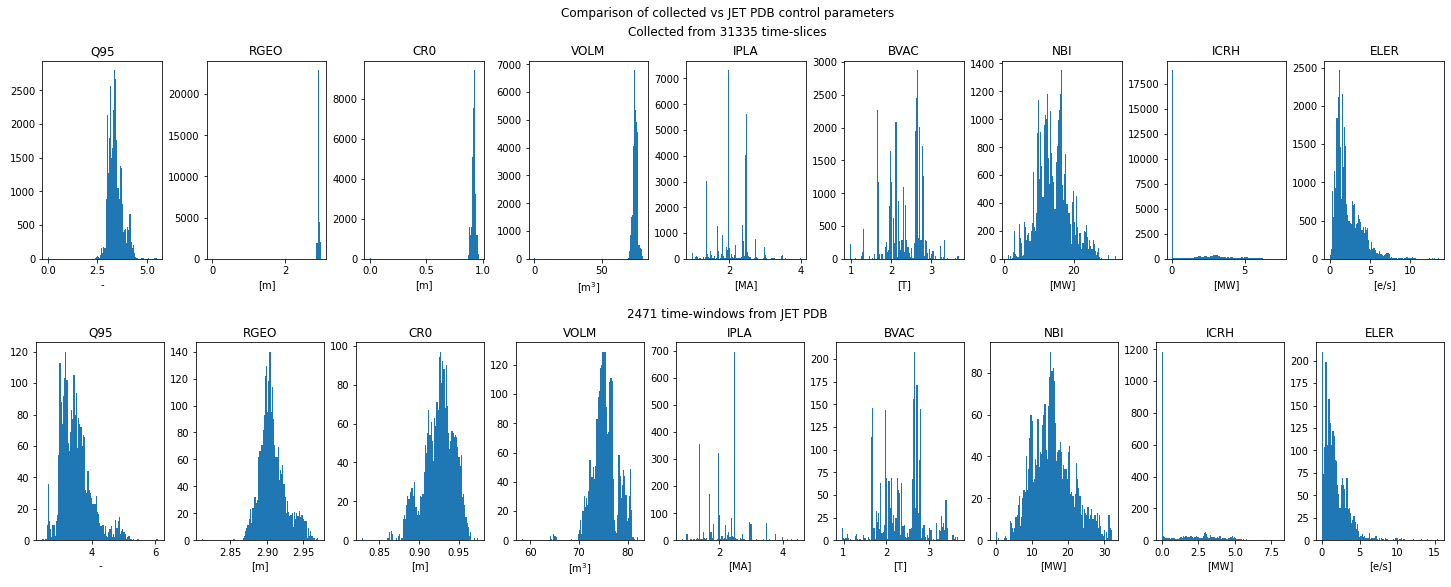

In [246]:

all_dict = big_dict['all_dict']
all_profs, all_radii, all_controls, all_ids, all_masks = all_dict['padded']['profiles'], all_dict['padded']['radii'], all_dict['padded']['controls'], all_dict['padded']['pulse_time_ids'], all_dict['padded']['masks']
MP_NAME_LIST = ['Q95', 'RGEO', 'CR0', 'VOLM', 'TRIU', 'TRIL', 'ELON', 'POHM', 'IPLA', 'BVAC', 'NBI', 'ICRH', 'ELER']
JETPDB_NAME_LIST = ['q95', 'R(m)', 'a(m)', 'plasmavolume(m^3)','averagetriangularity','averagetriangularity', 'averagetriangularity', 'averagetriangularity','Ip(MA)', 'B(T)',  'P_NBI(MW)','P_ICRH(MW)', 'gasflowrateofmainspecies10^22(e/s)', ]
comparison_dict = {'Raw Current': np.zeros(len(all_controls)), 'Raw Q95': np.zeros(len(all_controls))}

from scipy.stats import kstest, ttest_ind

plt.close()

fig = plt.figure(constrained_layout=True, figsize=(20, 8)) 
fig.suptitle('Comparison of collected vs JET PDB control parameters')

subfigs = fig.subfigures(nrows=2, ncols=1)

for row, (subfig, label) in enumerate(zip(subfigs, ['Collected from {} time-slices'.format(len(all_profs)), '{} time-windows from JET PDB'.format(len(PULSE_DF))])): 
    subfig.suptitle(label)
    
    
    cols_to_plot = [0, 1, 2, 3, 8, 9, 10, 11, 12]
    units = ['-', '[m]', '[m]', r'[m$^3$]', '[MA]', '[T]', '[MW]', '[MW]', '[e/s]']
    axs = subfig.subplots(nrows=1, ncols=len(cols_to_plot))
    for col, (ax, tup) in enumerate(zip(axs, cols_to_plot)): 
        ax.set_title(MP_NAME_LIST[tup])
        if label != '{} time-windows from JET PDB'.format(len(PULSE_DF)): 
            if tup == 8: 
                ax.hist(-all_controls[:, tup]*1e-6, bins=100)
            elif tup == 9: 
                ax.hist(-all_controls[:, tup], bins=100)
            elif tup == 10 or tup == 11: 
                ax.hist(all_controls[:, tup]*1e-6, bins=100)
            elif tup == 12: 
                ax.hist(all_controls[:, tup]*1e-22, bins=100)
            else: 
                ax.hist(all_controls[:, tup], bins=100)
        else: 
            ax.hist(PULSE_DF[JETPDB_NAME_LIST[tup]], bins=100)
        
        ax.set_xlabel(units[col])
            
plt.show()

- Compare the JET PDB values with raw profile values 
- Recreate plots in Lorenzo PRL nesep vs teped 


In [247]:

all_dict = big_dict['all_dict']
all_profs, all_radii, all_controls, all_ids, all_masks = all_dict['padded']['profiles'], all_dict['padded']['radii'], all_dict['padded']['controls'], all_dict['padded']['pulse_time_ids'], all_dict['padded']['masks']

pbar = tqdm(enumerate(all_ids))

comparison_dict = {'nesep_raw': np.zeros(len(all_profs)), 'nesep_te_100': np.zeros(len(all_profs)), 'nesep_steepest_2': np.zeros(len(all_profs)), 
                   'tesep_raw': np.zeros(len(all_profs)), 'tesep_steepest': np.zeros(len(all_profs)), 
                    'nesep_pdb_exp': np.zeros(len(all_profs)), 'psi_steepest': np.zeros(len(all_profs))}
for index, pulse_id in pbar: 
    # pulse_num, t1, t2 = int(row['shot']), row['t1'], row['t2']
    pulse_num = pulse_id.split('/')[0]
    pbar.set_postfix({'#': pulse_num})
    pulse_mask = all_masks[index] > 0
    
    pulse_d, pulse_t, pulse_radii, pulse_control = all_profs[index][0], all_profs[index][1], all_radii[index], all_controls[index]
    pulse_d, pulse_t = pulse_d[pulse_mask], pulse_t[pulse_mask]
    pulse_radii = pulse_radii[pulse_mask]
    
    
    tsep_100_mask = np.logical_and(pulse_t > 0.1, pulse_t<500)
    l = 10
    while len(pulse_t[tsep_100_mask]) < 2:
        tsep_100_mask = np.logical_and(pulse_t > 0.1, pulse_t<500+l)
        l += 10
        
    tsep_100 = pulse_t[tsep_100_mask]
    nesep_t100 = pulse_d[tsep_100_mask]
    
    
    grads = np.gradient(pulse_d)
    szedif = len(pulse_d) - len(grads[-6:])
    steepest_point = np.argmin(grads[-6:]) + szedif
    if steepest_point == 0: 
        steepest_point += 1
    two_closest = np.mean(pulse_d[steepest_point - 1:steepest_point + 1])    
    
    row = PULSE_DF.loc[PULSE_DF['shot'] == int(pulse_num)]
    
    PDB_nesep_exp = row['neseparatrixfromexpdata10^19(m^-3)']
    PDB_nesep_fit = row['neseparatrixfromfit10^19(m^-3)']
    l = 0.01
    sep_mask = np.logical_and(pulse_radii > 0.99, pulse_radii < 1.01)
    
    while len(pulse_d[sep_mask]) < 2: 
        l += 0.01
        sep_mask = np.logical_and(pulse_radii > 0.99 - l, pulse_radii < 1.01 + l)
    d_sep_pulse, t_sep_pulse = pulse_d[sep_mask], pulse_t[sep_mask]
    
    
    
    comparison_dict['nesep_raw'][index] = np.mean(d_sep_pulse)
    # comparison_dict['nesep_steepest_4'][index] = np.mean(four_closest)
    comparison_dict['nesep_steepest_2'][index] = np.mean(two_closest)
    comparison_dict['nesep_te_100'][index] = np.mean(nesep_t100)
    comparison_dict['nesep_pdb_exp'][index] = np.mean(PDB_nesep_exp)
    comparison_dict['psi_steepest'][index] = pulse_radii[steepest_point]
    # comparison_dict['tesep_raw']
    
    # print(PDB_nesep_fit)
    
    
    # print(row.columns.to_list())


0it [00:00, ?it/s]

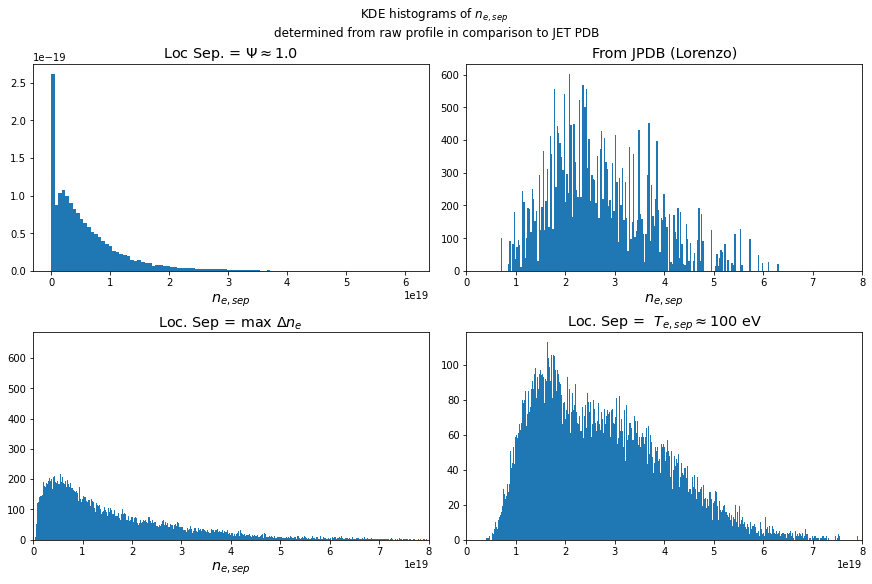

In [248]:
plt.close()

fig, axs = plt.subplots(2, 2, constrained_layout=True, figsize=(12, 8)) 
axs = axs.ravel()

non_zero = comparison_dict['nesep_pdb_exp'] > 0.0
axs[0].hist(comparison_dict['nesep_raw'][non_zero], density=True,bins=100)
axs[0].set_title(r'Loc Sep. = $\Psi \approx 1.0$',fontsize='x-large')
axs[0].set_xlabel('$n_{e,sep}$',fontsize='x-large') 
axs[1].hist(comparison_dict['nesep_pdb_exp'][non_zero], bins=200)
axs[1].set_title('From JPDB (Lorenzo)',fontsize='x-large')
axs[1].set_xlabel('$n_{e,sep}$',fontsize='x-large') 
axs[1].set_xlim(0, 8)
axs[2].hist(comparison_dict['nesep_steepest_2'][non_zero], bins=1000)
axs[2].set_title('Loc. Sep = max $\Delta n_e$ ',fontsize='x-large')
axs[2].set_xlabel('$n_{e,sep}$',fontsize='x-large') 
axs[2].set_xlim(0, 8e19)

axs[3].hist(comparison_dict['nesep_te_100'][non_zero], bins=1000)
axs[3].set_title(r'Loc. Sep =  $T_{e,sep} \approx 100 $ eV ', fontsize='x-large')
# axs[3].set_xlabel('$\Psi (\Delta n_e = $ max )', fontsize='x-large') 
axs[3].set_xlim(0, 8e19)
fig.suptitle('KDE histograms of $n_{e,sep}$  \ndetermined from raw profile in comparison to JET PDB' )

plt.show()
# comparison_dict['nesep_raw']

In [420]:
all_dict = big_dict['all_dict']
all_profs, all_radii, all_controls, all_ids, all_masks = all_dict['padded']['profiles'], all_dict['padded']['radii'], all_dict['padded']['controls'], all_dict['padded']['pulse_time_ids'], all_dict['padded']['masks']

notable_profiles = []

pbar = tqdm(enumerate(all_ids))

for index, pulse_id in pbar: 
    # pulse_num, t1, t2 = int(row['shot']), row['t1'], row['t2']
    pulse_num = pulse_id.split('/')[0]
    if pulse_num != '83356': 
        continue 
    notable_profiles.append(index)

0it [00:00, ?it/s]

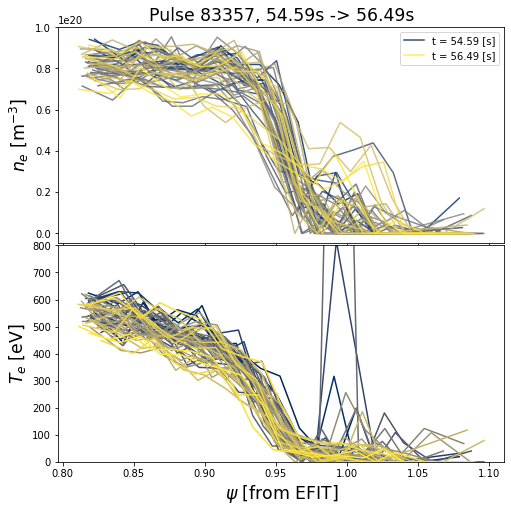

In [470]:
profs, radii, masks = all_profs[notable_profiles], all_radii[notable_profiles], all_masks[notable_profiles] > 0
plt.close()
# "fig, axs  = plt.subplots(2, 1, sharex=True, figsize=(5, 8), hspace=0.001)
import cycler 

n = len(notable_profiles)
color = plt.cm.cividis(np.linspace(0, 1,n))
plt.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)

fig = plt.figure(figsize=(8, 8))
gs = fig.add_gridspec(2, hspace=0.01)
axs = gs.subplots(sharex=True)

for i in range(len(profs)): 
    if i == 0: 
        label = 't = 54.59 [s]'
    elif i == len(profs) -1: 
        label = 't = 56.49 [s]'
    else: 
        label = None
    axs[0].plot(radii[i][masks[i]], profs[i, 0][masks[i]], label=label, alpha=0.8)
    
axs[0].set_title('Pulse 83357, 54.59s -> 56.49s', fontsize='xx-large')
for i in range(len(profs)): 
    axs[1].plot(radii[i][masks[i]], profs[i, 1][masks[i]])
axs[1].set_ylim(0, 800)
axs[0].set_ylabel('$n_e$ [m$^{-3}$]', fontsize='xx-large')
axs[1].set_ylabel('$T_e$ [eV]', fontsize='xx-large')
axs[1].set_xlabel(r'$\psi$ [from EFIT]', fontsize='xx-large')
axs[0].legend()
plt.show()

In [ ]:
JET PDB COLS = ['Tepedheight(keV)', 'nepedheight10^19(m^-3)',
'TepsiN=0.9pre-ELM(keV)', 'nepsiN=0.9pre-ELM10^19(m^-3)',
'neseparatrixfromexpdata10^19(m^-3)', 'neseparatrixfromfit10^19(m^-3)',]
